In [5]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from utils import similar_proteins, c1_c2_c3
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score, average_precision_score
import seaborn as sns

In [6]:
df_prot_list = pd.read_csv('../data/processed/protein_list.csv', header=None)
idx = df_prot_list[1].tolist()
idx_map = dict(zip(df_prot_list[0], df_prot_list[1]))
prot_map = dict(zip(df_prot_list[1], df_prot_list[0]))
mmseqs_file = '../data/alnRes.m8'

In [7]:
def get_pr_data(ratio, subset):
    p, r, m = np.array([]), np.array([]), np.array([])
    for model_name in ['GNN_ProtBert', 'GNN_one-hot', 'FFNN', 'LR']:
        rocs = []
        prs = []
        for cv in range(10):
            train = pd.read_csv('../data/processed/cv/'+ str(cv) + '/' + str(ratio) +'/train.csv')
            train_pos = train[train['label'] == 1].iloc[:,:2].values
            train_prots = [prot_map[x] for x in train_pos.flatten()]
            all_prots = [prot_map[x] for x in idx]
            train_nodes_sim = similar_proteins(train_prots, all_prots, mmseqs_file, seq_id = 0.4)
            train_nodes_sim = [idx_map[x] for x in train_nodes_sim]

            results = '../data/results/cv/' + str(cv) + '/' + str(ratio) + '/' + model_name + '/' + 'results.csv'
            df = pd.read_csv(results)

            isin = np.isin(df.iloc[:,:2].values, train_nodes_sim)
            isin_sum = np.sum(isin, axis=1)

            if subset == 'C1':
                c = df[isin_sum == 2]
            elif subset == 'C2':   
                c = df[isin_sum == 1]
            elif subset == 'C3':
                c = df[isin_sum == 0]
            
            if subset == 'C3' and model_name == 'LR':
                continue
                
            pred, y = c.iloc[:,3].values, c.iloc[:,2].values
            precision, recall, _ = precision_recall_curve(y, pred)
            rocs.append(roc_auc_score(y, pred))
            prs.append(average_precision_score(y, pred))
            intervals = 1001
            f = interp1d(recall, precision)
            recall_new = np.linspace(0, 1, num=intervals, endpoint=True)
            precision_new = f(recall_new)

            p = np.concatenate([p, precision_new])
            r = np.concatenate([r, recall_new])        
            m = np.concatenate([m, [model_name]*intervals])
        
        print(model_name, ratio, subset)
        print('ROC', np.mean(rocs), 2*np.std(rocs), 'PR', np.mean(prs), 2*np.std(prs))
    data = pd.DataFrame(np.array([p,r]).T).rename(columns={0:'Precision', 1:'Recall'})
    data['Model'] = m
    
    return data

In [8]:
data_c1_1 = get_pr_data(1, 'C1')
data_c2_1 = get_pr_data(1, 'C2')
data_c3_1 = get_pr_data(1, 'C3')

GNN_ProtBert 1 C1
ROC 0.9356439492129788 0.006675641739529679 PR 0.9372377766541513 0.005953495007029832
GNN_one-hot 1 C1
ROC 0.9159064714434602 0.0072964293185979875 PR 0.9264954857272834 0.0069748166450543155
FFNN 1 C1
ROC 0.9232167946226634 0.003287666471299776 PR 0.9236143951019455 0.0035778633526220038
LR 1 C1
ROC 0.8930896511395041 0.0024633970072238864 PR 0.8930628319796294 0.002201121502298717
GNN_ProtBert 1 C2
ROC 0.7078696822602 0.011906338588039793 PR 0.7112563212743288 0.015773249999793525
GNN_one-hot 1 C2
ROC 0.49242584228171643 0.13741447569288778 PR 0.46961410088385247 0.09213855704257279
FFNN 1 C2
ROC 0.7979907012436543 0.01140271534699249 PR 0.7948120232581004 0.012396058917952152
LR 1 C2
ROC 0.7977481629543726 0.01299981639060077 PR 0.8134276890108868 0.010576611398529103
GNN_ProtBert 1 C3
ROC 0.6365363127677933 0.1263428633855038 PR 0.6646796260726766 0.12029088188195144
GNN_one-hot 1 C3
ROC 0.4802936981480048 0.13514400887523392 PR 0.5076227631450869 0.0919495777663

In [9]:
data_c1_10 = get_pr_data(10, 'C1')
data_c2_10 = get_pr_data(10, 'C2')
data_c3_10 = get_pr_data(10, 'C3')

GNN_ProtBert 10 C1
ROC 0.9353033443210965 0.006892537170384005 PR 0.6980754965604581 0.02673364097824139
GNN_one-hot 10 C1
ROC 0.9157844162144553 0.006611663665604297 PR 0.6903107368370541 0.031048140133291213
FFNN 10 C1
ROC 0.923251178740746 0.004028262123568222 PR 0.6502642743879401 0.014613370242909828
LR 10 C1
ROC 0.8928992233013078 0.002329847662833732 PR 0.5543887242294405 0.006579780578268816
GNN_ProtBert 10 C2
ROC 0.7092826465080228 0.016291583993175048 PR 0.23960952573689293 0.01998342544059793
GNN_one-hot 10 C2
ROC 0.4927443482582309 0.14170173192536362 PR 0.0849279394912304 0.03165682192377926
FFNN 10 C2
ROC 0.8020123318529425 0.012874055604360538 PR 0.3475323709007271 0.026306122888891958
LR 10 C2
ROC 0.7983123571169334 0.011729995238050734 PR 0.4162717591986255 0.019051489201175317
GNN_ProtBert 10 C3
ROC 0.648753749242077 0.07305452350090898 PR 0.23007806369202194 0.08903963176986325
GNN_one-hot 10 C3
ROC 0.47899551543941127 0.09688082851110523 PR 0.09644771172526251 0.034

In [10]:
data_c1_100 = get_pr_data(100, 'C1')
data_c2_100 = get_pr_data(100, 'C2')
data_c3_100 = get_pr_data(100, 'C3')

GNN_ProtBert 100 C1
ROC 0.9353528266521265 0.006929874893917905 PR 0.30319807877608435 0.03804027991948264
GNN_one-hot 100 C1
ROC 0.9158776263200196 0.0067069028043119025 PR 0.2983155811524364 0.04467418728319689
FFNN 100 C1
ROC 0.9232739509455037 0.003986569779709879 PR 0.24960624631253464 0.01447779162993924
LR 100 C1
ROC 0.8929118539941536 0.0023779056265521184 PR 0.15877773732698947 0.0021168116240191165
GNN_ProtBert 100 C2
ROC 0.7092897718206689 0.015861447705959996 PR 0.03781468877899908 0.0062002138739090445
GNN_one-hot 100 C2
ROC 0.4935709512570714 0.1394349668606959 PR 0.00927041828780141 0.0037045046077356513
FFNN 100 C2
ROC 0.8009969094994055 0.012215372493436193 PR 0.06257335828449705 0.00623821425915451
LR 100 C2
ROC 0.7977704837132773 0.011743597967717949 PR 0.11184720147196447 0.010877648436939155
GNN_ProtBert 100 C3
ROC 0.6522083419757214 0.07761549517467112 PR 0.056722315806349954 0.04038675566902421
GNN_one-hot 100 C3
ROC 0.48455350886328874 0.08963096776876826 PR 0.0

<Figure size 432x288 with 0 Axes>

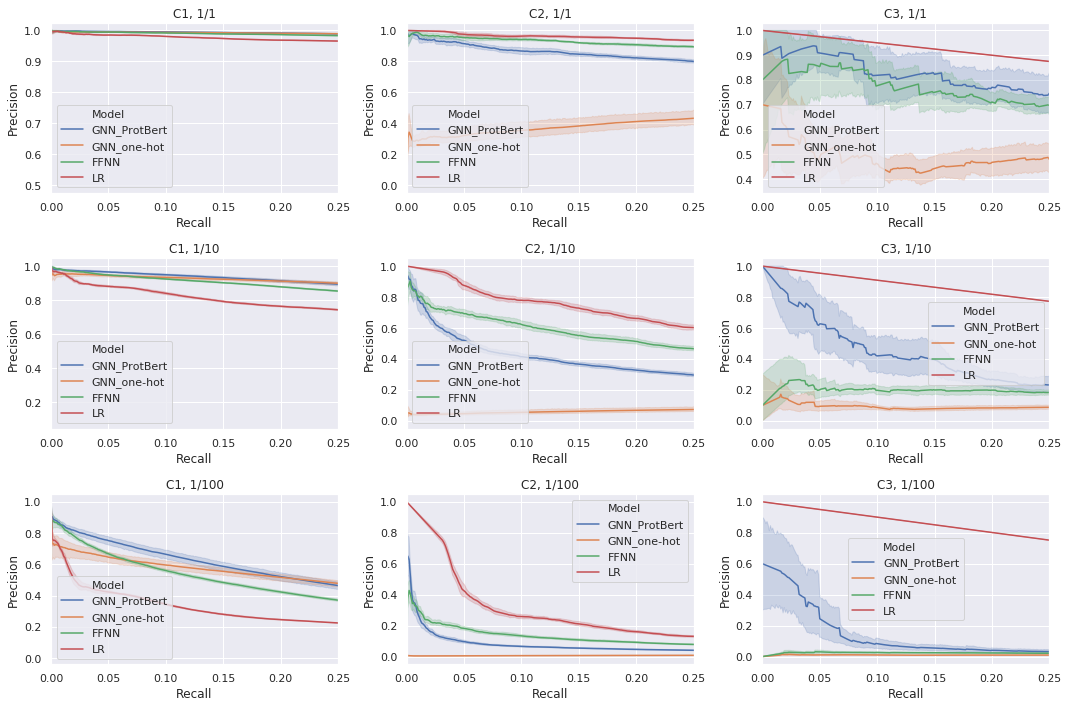

In [11]:
sns.set()
plt.tight_layout()
fig, axs = plt.subplots(3, 3, figsize=(15,10))
titles = ['C1, 1/1', 'C1, 1/10', 'C1, 1/100',\
          'C2, 1/1', 'C2, 1/10', 'C2, 1/100',\
          'C3, 1/1', 'C3, 1/10', 'C3, 1/100']

data = [data_c1_1, data_c1_10, data_c1_100,\
        data_c2_1, data_c2_10, data_c2_100,\
        data_c3_1, data_c3_10, data_c3_100,]

for i in range(3):
    for j in range(3):
        k = j*3+i
        sns.lineplot(data=data[k], x='Recall', y='Precision', hue='Model', ax=axs[i,j])
        axs[i,j].set_title(titles[k])
        axs[i,j].set_xlim(0,0.25)
        
    

fig.tight_layout()
plt.savefig('final.png')